# TMA01 Question 2 (50 marks)

**Name**: Diran Suraj

**PI**: Z7279378

In this question you will attempt to distinguish the type of traffic, given that you've already identified it as being sent over a VPN or not.

Each flow is labelled according to the type of traffic.

| Traffic | Content |
|---------|---------|
| Web Browsing | Firefox and Chrome |
| Chat | ICQ, AIM, Skype, Facebook and Hangouts | 
| Streaming | Vimeo and Youtube | 
| Email | SMPTS, POP3S and IMAPS | 
| VoIP |Facebook, Skype and Hangouts voice calls (1h duration) | 
| P2P | uTorrent and Transmission (Bittorrent) |
| FT (File Transfer) | Skype, FTPS and SFTP using Filezilla and an external service | 

Note that there are **two** collections of datasets: one for traffic sent over a VPN, and one for traffic not sent over a VPN. Each collection has training, validation, and test data.

## Completing the question
The tasks in this notebook can be addressed using the techniques discussed in the Foundation and Block 1 of the module materials, and the associated notebooks.

> **You should be able to complete this question when you have completed the practical activities in Block 1**
>
> You should look at the notebooks for Block 1 while working through this question. You will find many useful examples in those notebooks which will help you in this assignment.

Record all your activity and observations in this notebook. Insert additional notebook cells as required. Remember to run each cell in sequence and to rerun cells if you make any changes in earlier cells. 

Include Markdown cells (like this one) liberally in your solutions, to describe what you are doing. This will help your tutor give full credit for all you have done, and is invaluable in reminding you what you were doing when you return to the TMA after a few days away.

Before you submit your notebook make sure you run all cells in order and check that you get the results you expect. (It is not unknown to receive notebooks which don't work when the cells are run in order.)

See the VLE for details of how to submit your completed notebook. You should submit only this notebook file for this question.

## Marks are based on process, not results

In this notebook, you will be asked to create, train, and evaluate several neural networks. Training neural networks is inherently a stochastic process, based on the random allocation of initial weights and the shuffled order of training examples. Therefore, your results will differ from results generated by other students, and those generated by the module team and presented in the tutor's marking guide.

The marks in this question are awarded solely on your ability to carry out the steps of training and evaluation, not on any particular results you may achieve. **There are no thresholds for accuracy (or any other metric) you must achieve.** You will gain credit for carrying out the tasks specified in this question, including honest evaluations of how the models perform. 

## Setup

This imports the required libraries and loads the data into training, validation, and testing datasets.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils

import os
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML, display

## Loading and preparing the dataset

This section of the notebook loads the dataset and makes it available for training.

First, we define some constants we will use later and define some metrics to use for model evaluation.

In [6]:
BATCH_SIZE = 64

In [7]:
class_names = {i: n.strip() for i, n in enumerate(open('/datasets/cybersecurity/vpn-nonvpn/class_names.txt'))}
class_names

{0: 'BROWSING',
 1: 'CHAT',
 2: 'STREAMING',
 3: 'MAIL',
 4: 'VOIP',
 5: 'P2P',
 6: 'FT'}

In [8]:
class_names_array = np.array([class_names[i] for i in sorted(class_names)])
class_names_array

array(['BROWSING', 'CHAT', 'STREAMING', 'MAIL', 'VOIP', 'P2P', 'FT'],
      dtype='<U9')

In [9]:
def pretty_cm(cm):
    result_table  = '<h3>Confusion matrix</h3>\n'
    result_table += '<table border=1>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td><th colspan=10}>Predicted labels</th></tr>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td>'

    for cn in class_names.values():
        result_table += f'<td><strong>{cn}</strong></td>'
    result_table += '</tr>\n'

    result_table += '<tr>\n'
    result_table += '<th rowspan=11>Actual labels</th>\n'

    for ai, an in class_names.items(): # enumerate(class_names):
        result_table += '<tr>\n'
        result_table += f'  <td><strong>{an}</strong></td>\n'
        for pi, pn in class_names.items(): #enumerate(class_names):
            result_table += f'  <td>{cm[ai, pi]}</td>\n'
        result_table += '</tr>\n'
    result_table += "</table>"
    # print(result_table)
    display(HTML(result_table))

In [10]:
def multi_class_precision(cmatrix):
    s = cmatrix.shape[0]
    numerator = tf.reduce_sum(tf.linalg.diag(tf.ones(s)) * cmatrix, axis=0)
    denominator = tf.cast(tf.reduce_sum(cmatrix, axis=0), tf.float32)
    return numerator / denominator

In [11]:
def multi_class_recall(cmatrix):
    s = cmatrix.shape[0]
    numerator = tf.reduce_sum(tf.linalg.diag(tf.ones(s)) * cmatrix, axis=1)
    denominator = tf.cast(tf.reduce_sum(cmatrix, axis=1), tf.float32)
    return numerator / denominator

Where to find the data.

In [12]:
base_dir = '/datasets/cybersecurity/vpn-nonvpn/'

In [13]:
train_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_VPN_train'))
train_vpn_data = train_vpn_data.cache()
train_vpn_data = train_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
train_vpn_data = train_vpn_data.shuffle(1000)
train_vpn_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [14]:
validation_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_VPN_validation'))
validation_vpn_data = validation_vpn_data.cache()
validation_vpn_data = validation_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
validation_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [15]:
test_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_VPN_test'))
test_vpn_data = test_vpn_data.cache()
test_vpn_data = test_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
test_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [16]:
train_no_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_NO-VPN_train'))
train_no_vpn_data = train_no_vpn_data.cache()
train_no_vpn_data = train_no_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
train_no_vpn_data = train_no_vpn_data.shuffle(1000)
train_no_vpn_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [17]:
validation_no_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_NO-VPN_validation'))
validation_no_vpn_data = validation_no_vpn_data.cache()
validation_no_vpn_data = validation_no_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
validation_no_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [18]:
test_no_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_NO-VPN_test'))
test_no_vpn_data = test_no_vpn_data.cache()
test_no_vpn_data = test_no_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
test_no_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [19]:
input_shape = (train_vpn_data.element_spec[0].shape[1],)
num_classes = train_vpn_data.element_spec[1].shape[1]
input_shape, num_classes

((23,), 7)

## Validation and test labels    

Use these for generating confusion matrices.

In [20]:
validation_vpn_labels = np.array(list(validation_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_vpn_labels = np.argmax(validation_vpn_labels, axis=1)
validation_vpn_labels.shape

(979,)

In [21]:
validation_no_vpn_labels = np.array(list(validation_no_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_no_vpn_labels = np.argmax(validation_no_vpn_labels, axis=1)
validation_no_vpn_labels.shape

(896,)

In [22]:
test_vpn_labels = np.array(list(test_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_vpn_labels = np.argmax(test_vpn_labels, axis=1)
test_vpn_labels.shape

(1958,)

In [23]:
test_no_vpn_labels = np.array(list(test_no_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_no_vpn_labels = np.argmax(test_no_vpn_labels, axis=1)
test_no_vpn_labels.shape

(1792,)

# Part a (14 marks)

Create a four layer model. The first two layers should have 64 units, the third should have 32 units, and the last should have 7 units (for the seven classes of traffic). Note that you will need an initial `Input` layer with `shape=input_shape`.

The first three layers should use `sigmoid` activation. The last layer should use `softmax` activation. 

The model summary should look like this.

```
Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,007 (31.28 KB)

 Trainable params: 8,007 (31.28 KB)

 Non-trainable params: 0 (0.00 B)
```

Store the model in a variable called `model_a`.

Use the RMSprop optimiser, with its default parameters, and train this model for **200** epochs. Train using the `train_vpn_data` and `validation_vpn_data` defined above, as per the module notebooks. 

Plot how the accuracy and loss change during training. Comment on your observations of training. 

Evaluate the model on the test dataset and generate a confusion matrix. Store the confusion matrix in a variable called `cmatrx_a`. Comment on this evaluation and confusion matrix.

#### Important
This is a multi-class classification task. You must use the `categorical_crossentropy` loss function for training. The final output layer should use the `softmax` activation function.

> **Hints**
> * When training for many epochs, you may want to pass in the parameter `verbose=0` to `model_a.fit()` to reduce the output verbiage.
> * You may want to save the model and the training history so you can reload it in a later session.

In [64]:
model_a = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'), 
    tf.keras.layers.Dense(64, activation='sigmoid'), 
    tf.keras.layers.Dense(32, activation='sigmoid'), 
    tf.keras.layers.Dense(7, activation='softmax')
])
model_a.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,007 (31.28 KB)

 Trainable params: 8,007 (31.28 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
opt = optimizers.RMSprop()
model_a.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
history_a = model_a.fit(train_vpn_data,
    validation_data=validation_vpn_data,
    epochs=200,
    verbose=0)

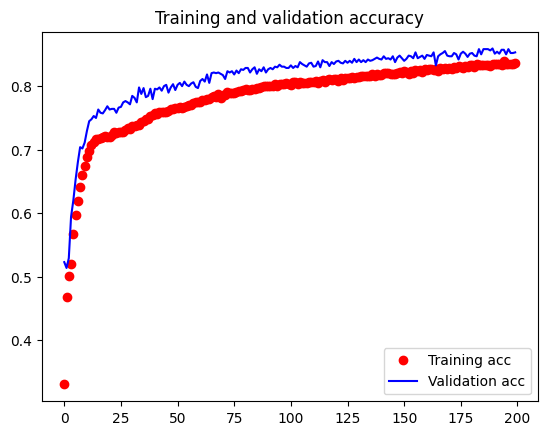

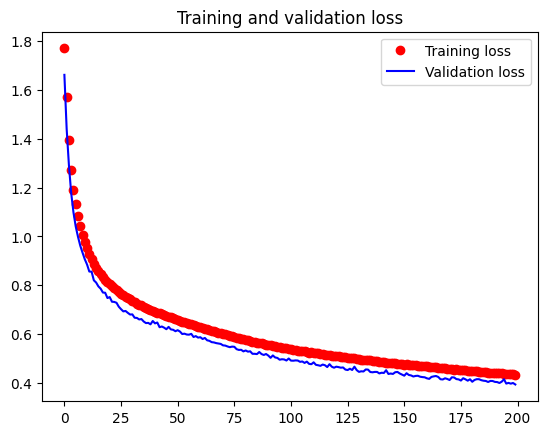

In [67]:
acc = history_a.history['accuracy']
val_acc = history_a.history['val_accuracy']
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The performance on the validation data is higher than the training data.

Both the training accuracy and the validation accuracy increase sharply, and then flatten around 12 epochs. Whereas, the training and validation loss begin fall more smoothly and the validation loss only starts to get closer to the training loss at 200 epochs.

In [68]:
model_a.evaluate(test_vpn_data, return_dict=True)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8274 - loss: 0.4769


{'accuracy': 0.836057186126709, 'loss': 0.45336243510246277}

In [69]:
test_predictions_a = model_a.predict(test_vpn_data)
predict_labels_a = np.argmax(test_predictions_a, axis=1)
test_vpn_labels_combined_a = predict_labels_a[:979]
cmatrix_a = tf.math.confusion_matrix(validation_vpn_labels, test_vpn_labels_combined_a).numpy()
pretty_cm(cmatrix_a)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


The test data showed an accuracy of 83%. 

The confusion matrix shows very poor classification overall, however the best predictions are for web browsing and VoIP.

# Part b (7 marks)

Create another model with the same structure as in part (a). Store this model in a variable called `model_b`. 

Train this model with the same hyperparameters as in part (a), but now using the `train_no_vpn_data` and `validation_no_vpn_data` datasets. 

Plot how the accuracy and loss change during training. Comment on your observations of training.

Evaluate the model on the test dataset and generate a confusion matrix. Store the confusion matrix in a variable called `cmatrix_b`. Comment on this evaluation and confusion matrix.

In [73]:
model_b = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'), 
    tf.keras.layers.Dense(64, activation='sigmoid'), 
    tf.keras.layers.Dense(32, activation='sigmoid'), 
    tf.keras.layers.Dense(7, activation='softmax')
])

In [74]:
opt = optimizers.RMSprop()
model_b.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [75]:
history_b = model_b.fit(train_no_vpn_data,
    validation_data=validation_no_vpn_data,
    epochs=200,
    verbose=0)

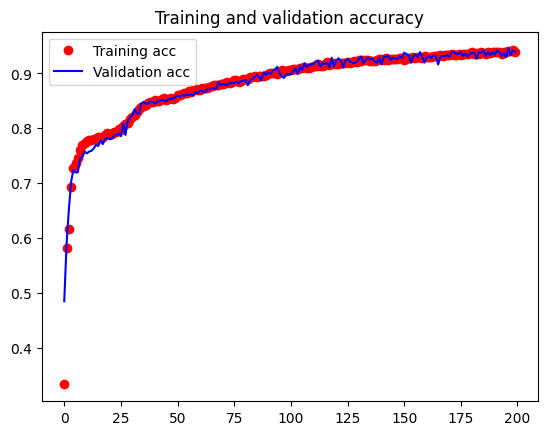

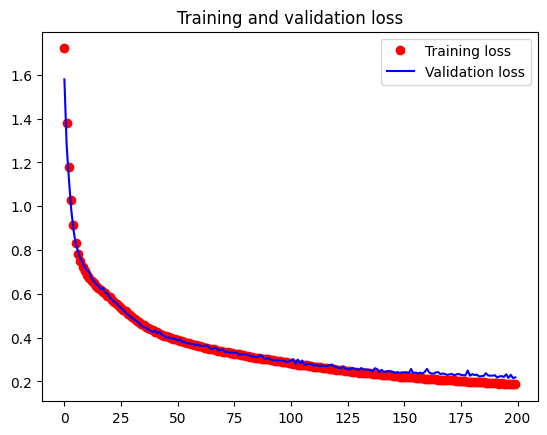

In [76]:
acc = history_b.history['accuracy']
val_acc = history_b.history['val_accuracy']
loss = history_b.history['loss']
val_loss = history_b.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The performance on the training data is very close to the validation data.

Both the training accuracy and the validation accuracy increase sharply, and then flatten around 150 epochs. Whereas, the training and validation loss begin to flatten around 125 epochs and the validation loss on slightly separates from the training loss.

Overall, this is better performance than the vpn data.

In [77]:
model_b.evaluate(test_no_vpn_data, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.9433 - loss: 0.1919


{'accuracy': 0.9358258843421936, 'loss': 0.20462478697299957}

In [78]:
test_predictions_b = model_b.predict(test_no_vpn_data)
predict_labels_b = np.argmax(test_predictions_b, axis=1)
test_no_vpn_labels_combined_b = predict_labels_b[:896]
cmatrix_b = tf.math.confusion_matrix(validation_no_vpn_labels, test_no_vpn_labels_combined_b).numpy()
pretty_cm(cmatrix_b)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


The test data showed an accuracy of 94%. 

The confusion matrix shows very poor classification overall, however the best predictions are for web browsing and VoIP.

# Part c (8 marks)

You now have two models, one trained on the VPN traffic and one trained on the non-VPN traffic. How good are these models, and how well do these models compare?

You can also now replicate the results presented by Draper-Gil _et al._ (2016) figure 3(a)-(d). 

Using the example below, generate and plot the multi-class precision and multi-class recall scores, based on each of the evaluation of the models created in parts (a) and (b) above. Plot those results in the four subplots of one figure, using the example below for guidance.

Comment on your results.

Compare your results to those presented by Draper-Gil _et al._ (2016) (paying most attention to the "15s" data, as that is what you're using). 

> Reminder: there are no marks awarded for how well your models do in comparison to those created by Draper-Gil _et al._ This question is about generating results and comparing them.

In [79]:
multi_class_precision(cmatrix_a)

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.299639  , 0.05494506, 0.02040816, 0.02083333, 0.2850679 ,
       0.13333334, 0.18719211], dtype=float32)>

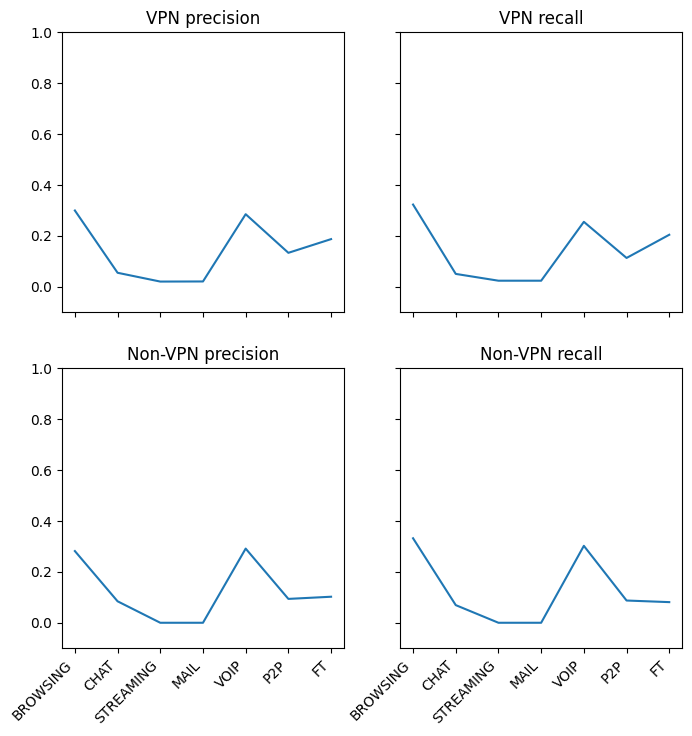

In [80]:
fig = plt.figure(figsize=(8, 8))
ax = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

ax[0, 0].plot(class_names_array, multi_class_precision(cmatrix_a).numpy())
ax[0, 0].set_title("VPN precision")
ax[0, 0].grid(axis='y')

# Add plot here
ax[0, 1].plot(class_names_array, multi_class_recall(cmatrix_a).numpy())
ax[0, 1].set_title("VPN recall")
ax[0, 0].grid(axis='y')

# Add plot here
ax[1, 0].plot(class_names_array, multi_class_precision(cmatrix_b).numpy())
ax[1, 0].set_title("Non-VPN precision")
ax[0, 0].grid(axis='y')

# Add plot here
ax[1, 1].plot(class_names_array, multi_class_recall(cmatrix_b).numpy())
ax[1, 1].set_title("Non-VPN recall")
ax[0, 0].grid(axis='y')

ax[1, 0].set_xticks(class_names_array, labels=class_names_array, rotation=45, horizontalalignment='right')
ax[1, 1].set_xticks(class_names_array, labels=class_names_array, rotation=45, horizontalalignment='right')
ax[1, 1].set_ylim((-0.1, 1.0))
plt.show()

The results show that web browsing and VoIP data have the highest recall and precision compared to the other data classes for both VPN and non-VPN traffic. However, compared to Draper-Gil's data, whilst his plots also show similar peaks with these data classes, overall his data has much high precision and recall for both VPN and non-VPN traffic.

# Part d (12 marks)

Create a four layer model with the same structure as parts (a) and (b) above. This new model should use `relu` activation rather than `sigmoid`. (The last layer must still use `softmax` activation.)

Store the models in variables called `model_d1` and `model_d2`.

Use the SGD optimiser, with its default parameters, and train these models for **300** epochs. 

Train `model_d1` using the `train_vpn_data` and `validation_vpn_data` defined above. Train `model_d2` using the `train_no_vpn_data` and `validation_no_vpn_data` defined above.

Plot how the accuracy and loss change during training. Comment on your observations of training. 

Evaluate the models on the appropriate test datasets and generate a confusion matrices. Comment on this evaluation and confusion matrices.

Compare the performance of the models against those you generated in parts (a) and (b) above.

In [24]:
model_d1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')
])

In [25]:
opt = optimizers.RMSprop()
model_d1.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history_d1 = model_d1.fit(train_vpn_data,
    validation_data=validation_vpn_data,
    epochs=300,
    verbose=0)

I0000 00:00:1730458848.686616      72 service.cc:145] XLA service 0x7fea8c00ec10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730458848.686651      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730458849.432529      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


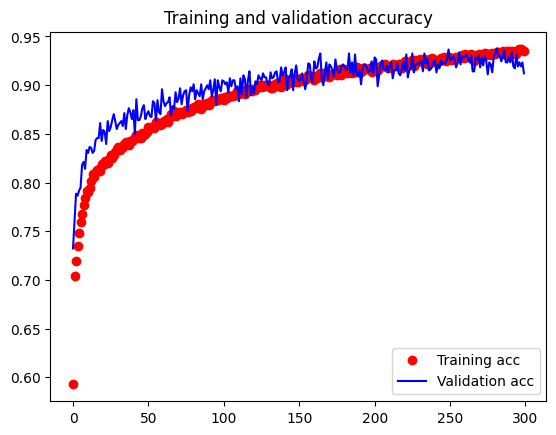

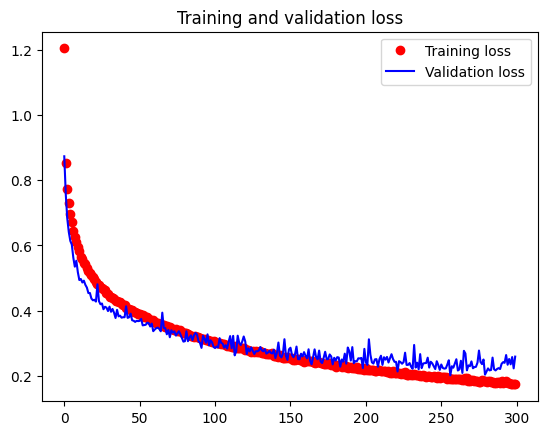

In [27]:
acc = history_d1.history['accuracy']
val_acc = history_d1.history['val_accuracy']
loss = history_d1.history['loss']
val_loss = history_d1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The performance on the training data is slighter higher than the validation data.

Both the training accuracy and the validation accuracy increase sharply, however the validation accuracy flattens out sooner especially after 150 epochs. The training and validation loss show a similar trend where validation loss flattens around 150 epochs and separates from training loss.

In [39]:
model_d1.evaluate(test_vpn_data, return_dict=True)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.9004 - loss: 0.3432


{'accuracy': 0.9024514555931091, 'loss': 0.3463484048843384}

In [71]:
test_predictions_d1 = model_d1.predict(test_vpn_data)
predict_labels_d1 = np.argmax(test_predictions_d1, axis=1)
test_vpn_labels_combined_d1 = predict_labels_d1[:979]
cmatrix_d1 = tf.math.confusion_matrix(validation_vpn_labels, test_vpn_labels_combined_d1).numpy()
pretty_cm(cmatrix_d1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


The test data showed an accuracy of 90%. 

The confusion matrix shows very poor classification overall, however the best predictions are for web browsing and VoIP.

In [57]:
model_d2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')
])

In [58]:
opt = optimizers.RMSprop()
model_d2.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
history_d2 = model_d2.fit(train_no_vpn_data,
    validation_data=validation_no_vpn_data,
    epochs=300,
    verbose=0)

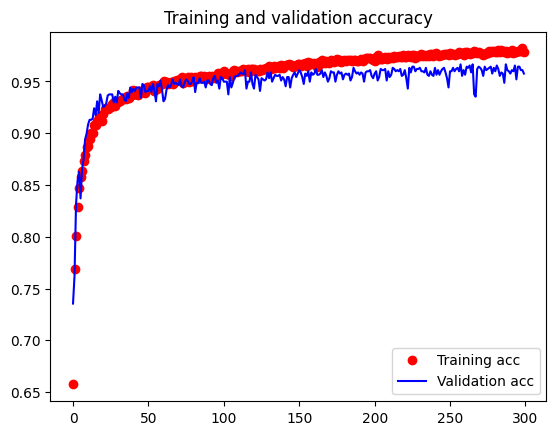

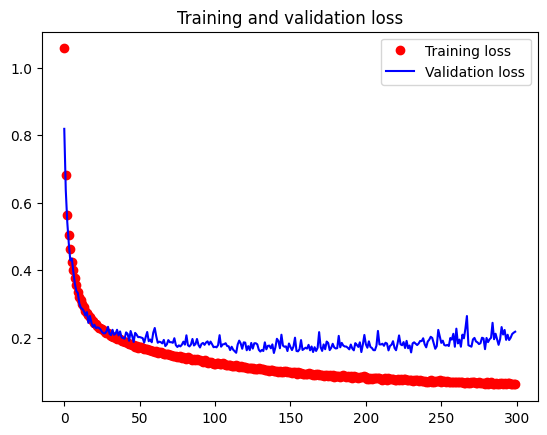

In [60]:
acc = history_d2.history['accuracy']
val_acc = history_d2.history['val_accuracy']
loss = history_d2.history['loss']
val_loss = history_d2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The performance on the training data is  higher than the validation data.

Both the training accuracy and the validation accuracy increase sharply, however the validation accuracy flattens out sooner especially after 100 epochs. The training and validation loss show a similar trend where validation loss flattens around 100 epochs and separates from training loss and evens begins to increase slightly around 200 epochs suggesting overfitting.

In [61]:
model_d2.evaluate(test_no_vpn_data, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9628 - loss: 0.1781


{'accuracy': 0.9587053656578064, 'loss': 0.23337247967720032}

In [70]:
test_predictions_d2 = model_d2.predict(test_no_vpn_data)
predict_labels_d2 = np.argmax(test_predictions_d2, axis=1)
test_no_vpn_labels_combined_d2 = predict_labels_d2[:896]
cmatrix_d2 = tf.math.confusion_matrix(validation_no_vpn_labels, test_no_vpn_labels_combined_d2).numpy()
pretty_cm(cmatrix_d2)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


The test data showed an accuracy of 96%. 

The confusion matrix shows very poor classification overall, however the best predictions are for web browsing and VoIP.

model_a and model_b had 83% and 94% accuracy respectively on the test data, whereas model_d1 and model_d2 had 90% and 96% accuracy respectively on the test data. This shows a significant improvement for the vpn data and a slight improvement for the no vpn data, likely due to the extra 100 epochs and relu activation layers in models d1 and d2.

The difference between the d1, d2 pair (6%) is also slightly smaller than the a, b pair (11%).

# Part e (3 marks)

One feature of neural network based models is that they only perform well on data that is similar to what they've been trained on. 

From the work above, you have two datasets (VPN and non-VPN) and a model trained on each. At first glance, the flows in these datasets should be similar to the other dataset. How well do the models from part (d) work on the dataset it was _not_ trained on?

Evaluate each model from part (d) against each test dataset. Compare the results between models and datasets. Comment on what you find.

In [94]:
model_d1.evaluate(test_no_vpn_data, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.5910 - loss: 4.1506


{'accuracy': 0.5848214030265808, 'loss': 4.404900074005127}

In [95]:
model_d2.evaluate(test_vpn_data, return_dict=True)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.4984 - loss: 12.0045


{'accuracy': 0.49284985661506653, 'loss': 12.117600440979004}

Both models appear to have significantly lower accuracy compared to their own datasets as expected. 

What is notable is that model_d1 has nearly a 10% improvement on model_d2 on this  data. This differs where model_d2 had a 10% lead on model_d1 with the datasets they were trained on.

# Part f (6 marks)

You can now address a simplified version of "scenario B" from the Draper-Gil _et al._ (2016) paper. This scenario attempts to classify flows by type, when the flows are a mixture of VPN and non-VPN traffic. However, you will only need to classify the flows into the current seven classes, rather than the fourteen in the paper.

The cell below combines the `vpn` and `no_vpn` datasets. 

Use this combined dataset to train another model, with the same structure as in part (d) above. Evaluate the model's performance on the `vpn`, `no_vpn`, and `all` datasets. How does this model compare to the models created in parts (a), (b), and (d)?

In [86]:
train_all_data = train_vpn_data.concatenate(train_no_vpn_data)
train_all_data = train_all_data.shuffle(200)

validation_all_data = validation_vpn_data.concatenate(validation_no_vpn_data)

test_all_data = test_vpn_data.concatenate(test_no_vpn_data)

test_all_labels = np.array(list(test_all_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_all_labels = np.argmax(test_all_labels, axis=1)

In [87]:
model_e = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(7, activation='softmax')
])

In [88]:
opt = optimizers.RMSprop()
model_e.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [89]:
history_e = model_e.fit(train_all_data,
    validation_data=validation_all_data,
    epochs=300,
    verbose=0)

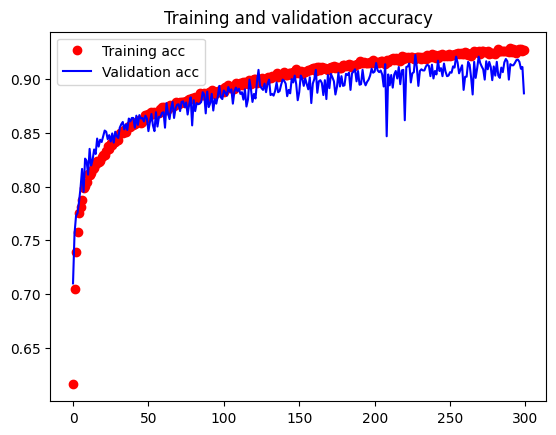

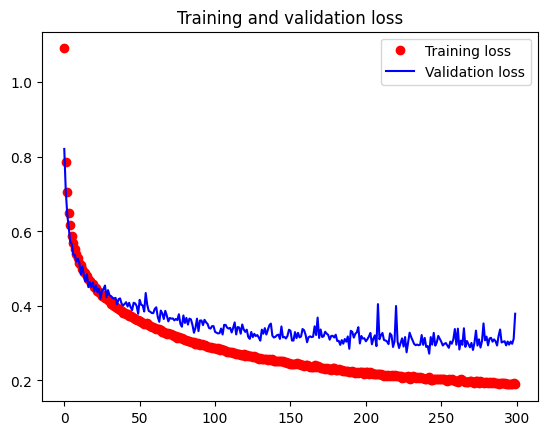

In [90]:
acc = history_e.history['accuracy']
val_acc = history_e.history['val_accuracy']
loss = history_e.history['loss']
val_loss = history_e.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The performance on the training data is  higher than the validation data.

Both the training accuracy and the validation accuracy increase sharply, where the validation accuracy slightly increments until it flattens out around 250 epochs. The training and validation loss show a similar trend where validation loss flattens around 250 epochs and is much more separated from the training loss.

This shows any further training may lead to overfitting.

In [91]:
model_e.evaluate(test_no_vpn_data, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9010 - loss: 0.2872


{'accuracy': 0.9073660969734192, 'loss': 0.3136218190193176}

In [92]:
model_e.evaluate(test_vpn_data, return_dict=True)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8695 - loss: 0.4427


{'accuracy': 0.875893771648407, 'loss': 0.43548914790153503}

In [93]:
model_e.evaluate(test_all_data, return_dict=True)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.8768 - loss: 0.4186


{'accuracy': 0.8909333348274231, 'loss': 0.3776538372039795}

In [111]:
test_no_vpn_labels_combined_e = test_all_labels[:896]
cmatrix_e1 = tf.math.confusion_matrix(validation_no_vpn_labels, test_no_vpn_labels_combined_e).numpy()
pretty_cm(cmatrix_e1)

In [107]:
test_vpn_labels_combined_e = test_all_labels[:979]
cmatrix_e2 = tf.math.confusion_matrix(validation_vpn_labels, test_vpn_labels_combined_e).numpy()
pretty_cm(cmatrix_e2)

model_e shows strong performance across the vpn, no vpn and combined datasets (88%, 90%, 89% respectively). As expected, compared to models a, b and d this performance is not only strong for a singular dataset but each separately and combined. This is likely because the model was trained on the combined dataset.

model e has 88% accuracy for vpn data whereas d1 has 90%, and a 83%. Likewise, model e has 90% accuracy for non-vpn data whereas d2 has 96%, and b 94%. This suggests a slight dip in performance of model e for the individual datasets but not too far off from the previous models.

The confusion matrix for model e does not seem too different compared to previous models either, appearing to be best at classifying web browsing and voip data but also misclassifying a lot of browsing data as voip and vice versa.